In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def Lmember(Cordinates, Connections,member=1):
    m=member
    Cord=Cordinates
    Conec=Connections
    x1,y1= Cord[Conec[m,0]][0], Cord[Conec[m,0]][1]
    x2,y2= Cord[Conec[m,1]][0], Cord[Conec[m,1]][1]
    L=np.power( (np.power((x1-x2),2) + np.power((y1-y2),2)),0.5)
    return L

In [3]:
#information availaable about the beam-(loads, boundary condition, nodes, node connectivity)


E=210e6
I=60e-6

dofs=np.array([[1,2], [3,4], [5,6]])-1
coordinates=np.array([(0,0),(2,0),(4,0)])
connections=np.array([(1,2),(2,3)])-1


dof_seq=np.array([3,4,6,1,2,5])-1 #unknows : knowns
free_dof=3 #number of DOFs which are free
ndof=len(coordinates)*2



P=np.zeros((ndof,))
U=np.zeros((ndof,))

P[2]=-20





In [4]:
membs=connections.shape[0]
Lenths=np.zeros((membs,))
for i in range(membs):
    Lenths[i]=Lmember(coordinates,connections,member=i)

In [5]:
print(Lenths)

[2. 2.]


In [6]:
km=np.zeros([membs,4,4])
for i in range(membs):
    L=Lenths[i]
    km[i]=np.array([[12*E*I/L**3, 6*E*I/L**2 , -12*E*I/L**3,  6*E*I/L**2],
              [ 6*E*I/L**2,  4*E*I/L, -6*E*I/L**2, 2*E*I/L],
              [-12*E*I/L**3,  -6*E*I/L**2, 12*E*I/L**3, -6*E*I/L**2 ],
              [ 6*E*I/L**2 , 2*E*I/L, -6*E*I/L**2, 4*E*I/L]])

In [7]:
#associated dof of each member-(DOF relation with the member)
dof_label=np.zeros((membs,4),dtype=int)
for i in range(membs):
    p,q=connections[i]
    dof_label[i]=np.concatenate((dofs[p],dofs[q]),)   
print(dof_label)  

[[0 1 2 3]
 [2 3 4 5]]


In [8]:
KG= np.zeros((ndof,ndof))
for k in range(km.shape[0]):
    for i in range(4):
        for j in range(4):
            x=int(dof_label[k][j])
            y=int(dof_label[k][i])         
            KG[x,y]= (KG[x,y]+km[k,i,j])

In [9]:
#Global Stiffness Matrix

np.set_printoptions(precision=4)
print('\n******************GLOBAL STIFFNESS MATRIX***************************\n')
print(KG/1000)


******************GLOBAL STIFFNESS MATRIX***************************

[[ 18.9  18.9 -18.9  18.9   0.    0. ]
 [ 18.9  25.2 -18.9  12.6   0.    0. ]
 [-18.9 -18.9  37.8   0.  -18.9  18.9]
 [ 18.9  12.6   0.   50.4 -18.9  12.6]
 [  0.    0.  -18.9 -18.9  18.9 -18.9]
 [  0.    0.   18.9  12.6 -18.9  25.2]]


### Post Processing

In [10]:

xx=free_dof

KG[:,:]=KG[dof_seq,:]
KG[:,:]=KG[:,dof_seq]

P[:,]=P[[dof_seq],]

pk=P[:xx,]
pu=P[xx:,]
uk=U[xx:,]  
uu=U[:xx,]

K11=KG[:xx,:xx]
K12=KG[:xx,xx:]
K21=KG[xx:,:xx]
K22=KG[xx:,xx:]

uu= np.matmul(np.linalg.inv(K11),pk)
pu=np.matmul(K21,uu)

UU=np.concatenate((uu,uk), axis=0)
FF=np.round(np.concatenate((pk,pu), axis=0),6)


for i in range(len(dof_seq)):
    U[dof_seq[i]]=UU[i]
    P[dof_seq[i]]=FF[i]
    
node_disp=np.vstack(U)
nodal_forces= np.vstack(P)



In [11]:
print('\n******************GLOBAL NODAL DISPLACEMENTS VECTOR***************************\n')
print(node_disp)


******************GLOBAL NODAL DISPLACEMENTS VECTOR***************************

[[ 0.    ]
 [ 0.    ]
 [-0.0009]
 [-0.0002]
 [ 0.    ]
 [ 0.0008]]


In [12]:
np.set_printoptions(precision=2)
print('\n******************GLOBAL NODAL FORCES VECTOR***************************\n')
print(nodal_forces)


******************GLOBAL NODAL FORCES VECTOR***************************

[[ 13.75]
 [ 15.  ]
 [-20.  ]
 [  0.  ]
 [  6.25]
 [  0.  ]]


In [13]:
#member dof displacements
eleU=np.zeros((membs,4))

In [14]:
for i in range(membs):
    p,q=connections[i]
    eleU[i]=np.concatenate((U[dofs[p]],U[dofs[q]]))

In [15]:
np.set_printoptions(precision=4)
print('\n******************Member DOF Displacements***************************\n')
print(eleU.T)


******************Member DOF Displacements***************************

[[ 0.     -0.0009]
 [ 0.     -0.0002]
 [-0.0009  0.    ]
 [-0.0002  0.0008]]


In [16]:
#member forces
memberforces=np.zeros(eleU.shape)
memberforces1=np.zeros(eleU.shape)
for i in range(membs):
    memberforces[i]=np.matmul(km[i],eleU[i])
memberforces1=np.copy(memberforces)

In [17]:
print(memberforces1.T)

[[ 13.75  -6.25]
 [ 15.   -12.5 ]
 [-13.75   6.25]
 [ 12.5    0.  ]]


In [18]:
print('\n******************Member Forces***************************\n')
print(memberforces.T)


******************Member Forces***************************

[[ 13.75  -6.25]
 [ 15.   -12.5 ]
 [-13.75   6.25]
 [ 12.5    0.  ]]


In [19]:
#modification forces for element 2 due to the distributed load
# memberforces[1]=memberforces[1]-np.array([0,-9.333,0,9.333])*1000 #np.array([-14,-9.333,-14,9.333])*1000

In [20]:
# memberforces1[1]=memberforces1[1]-np.array([-14,-9.333,-14,9.333])*1000

In [21]:
#final member forces
print('\n******************Final Member Forces***************************\n')
print(memberforces1.T)


******************Final Member Forces***************************

[[ 13.75  -6.25]
 [ 15.   -12.5 ]
 [-13.75   6.25]
 [ 12.5    0.  ]]


In [22]:
def figs(Lenths,member=1):
    member=member
    x=[0,Lenths[member]]
    y_bm=np.multiply(memberforces[member,[1,-1]],np.array([-1,1]))
    y_sf=np.multiply(memberforces[member,[0,2]],np.array([1,-1]))
    plt.plot(x,y_bm,color='b',label="BM")
    plt.title(f'Member {member+1}')
    plt.xlabel('Lenght-m')
    plt.ylabel('N-m')
    plt.legend()
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f'BM-Member{member+1}.png',dpi=100)
    plt.show()
    
    
    plt.plot(x,y_sf,color='g',label='SF')
    plt.xlabel('Lenght-m')
    plt.ylabel('N')
    plt.title(f'Member {member+1}')
    plt.legend()
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(f'SF-Member{member+1}.png',dpi=100)
    plt.show()

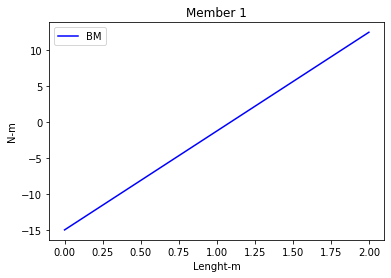

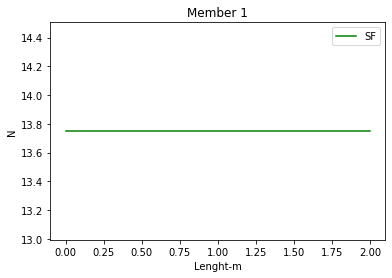

In [23]:
figs(Lenths,member=0)

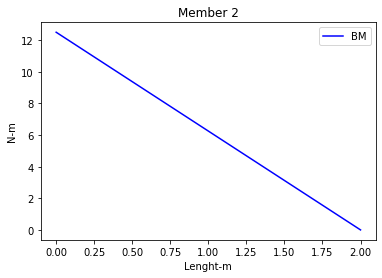

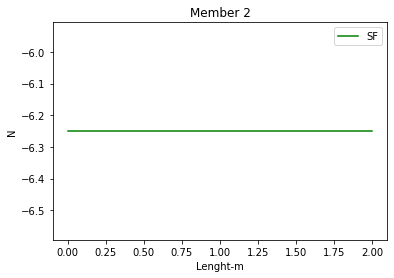

In [24]:
figs(Lenths,member=1)